# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [13]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle as pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Feature Estractors
#### Implementacion: Hog

In [2]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3
    CNN = 4

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)
	elif method == FeatureExtractors.CNN:
		image_representation = prep_for_cnn(image)
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
    return fd

def prep_for_cnn(img):
    #print(img.shape)
    if len(img.shape)==3 and img.shape[2] == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img/255.0

## Data Loader & ShowImg

In [3]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.HOG,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    positive_img_files = positive_img_files[:7500]
    negative_img_files = negative_img_files[:7500]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    validation_annotations= pd.read_pickle(os.path.join(validation_data_dir,'validation_bbox.pickle'))
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes

def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [129]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[0];
    w_cols = window_size[1];
    
    cc = (i_cols - w_cols)//step_size
    cr = (i_rows - w_rows)//step_size
    return cc*cr

def sliding_window(img, window_size, scale, step_size):
    
    scales = [scale, 3*(scale/4), scale/2, scale/4]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
    
    patches = np.zeros((window_size[0], window_size[1], ct))
    bbox_locations = np.zeros((ct, 4))
    
    i=0
    for image in images:
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [y, x,
                                           window_size[0]*(img.shape[0]/image.shape[0]),
                                           window_size[1]*(img.shape[1]/image.shape[1])]
                    i+= 1
                except:
                    pass
                    
    return patches, bbox_locations

## Test Sliding Window

In [29]:
! dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is F868-5BD0

 Directory of C:\Users\santi\OneDrive\Documents\GitHub\CV-final-project

06/09/2022  01:16 PM    <DIR>          .
06/06/2022  07:45 AM    <DIR>          ..
06/08/2022  10:30 AM    <DIR>          .ipynb_checkpoints
06/08/2022  10:32 AM             2,607 evaluation.py
06/09/2022  01:16 PM         7,198,023 Face Detection (moded).ipynb
06/07/2022  06:42 PM         1,899,921 Face Detection.ipynb
06/06/2022  07:46 AM    <DIR>          face_detection
06/08/2022  10:06 AM         3,569,736 face_detector
06/08/2022  10:06 AM         3,420,080 face_detector.h5
06/08/2022  10:54 AM         3,418,960 face_detector100.h5
06/09/2022  12:00 PM         3,420,080 face_detector20.h5
06/08/2022  12:08 PM         3,420,080 face_detector30.h5
06/06/2022  07:46 AM         2,838,000 Image Stiching.ipynb
06/06/2022  07:46 AM    <DIR>          images
06/06/2022  07:46 AM             8,906 image_utils.py
06/07/2022  06:42 PM         2,071,58

 31%|███       | 54/175 [00:00<00:00, 272.39it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 295.09it/s]

im [67 70 98]


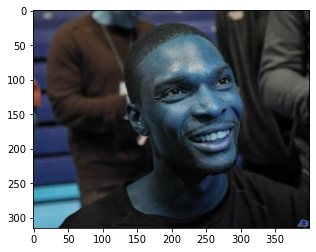

In [130]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

val_data, val_bboxes = load_validation_data(validation_faces_dir)

image = val_data[109]
gray_image = extract_features(FeatureExtractors.CNN, val_data[109])
print("im",image[3][3])
plt.imshow(image, cmap='gray')


[[  0.           0.         128.         128.        ]
 [  0.          32.         128.         128.        ]
 [  0.          64.         128.         128.        ]
 [  0.          96.         128.         128.        ]
 [  0.         128.         128.         128.        ]
 [  0.         160.         128.         128.        ]
 [  0.         192.         128.         128.        ]
 [  0.         224.         128.         128.        ]
 [  0.         256.         128.         128.        ]
 [ 32.           0.         128.         128.        ]
 [ 32.          32.         128.         128.        ]
 [ 32.          64.         128.         128.        ]
 [ 32.          96.         128.         128.        ]
 [ 32.         128.         128.         128.        ]
 [ 32.         160.         128.         128.        ]
 [ 32.         192.         128.         128.        ]
 [ 32.         224.         128.         128.        ]
 [ 32.         256.         128.         128.        ]
 [ 64.    

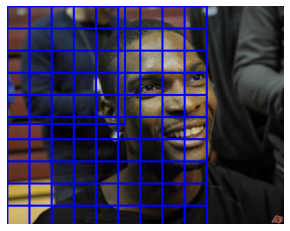

In [131]:
patches, bbox_locations = [], []
patches, bbox_locations = sliding_window(gray_image,(128, 128), 1, 32)

print(bbox_locations)
show_image_with_bbox(image, bbox_locations,
                     [0,0,0,0],
                     draw_GT=False)

In [91]:
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape;
    window_rows = window_size[0];
    window_cols = window_size[1];

    patches = np.zeros((window_rows, window_cols,5));
    bbox_locations = np.zeros((5,4))
    r = np.random.randint(0,image_rows-window_rows,5); # Sample top left position
    c = np.random.randint(0,image_cols-window_cols,5);
    for i in range(0,5):
        patches[:,:,i] = image[r[i]:r[i]+window_rows, c[i]:c[i]+window_cols];
        bbox_locations[i,:] = [r[i],c[i],window_rows,window_cols]; # top-left y,x, height, width


    return patches, bbox_locations

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [5]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'validation')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [6]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.CNN)

  1%|          | 69/7500 [00:00<00:10, 689.95it/s]

##Loading 7500 positive face images


  1%|          | 70/7489 [00:00<00:10, 699.96it/s]

##Loading 7489 negative face images


100%|██████████| 7489/7489 [00:09<00:00, 779.04it/s]


#### Load Validation Data

In [7]:
validation_data = load_validation_data(validation_faces_dir)

 13%|█▎        | 22/175 [00:00<00:00, 219.99it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 220.11it/s]


#### Entrenar el clasificador SVM de sklearn

In [ ]:
svm_classifier = svm.SVC(kernel='linear',
                         probability=True)

In [ ]:
svm_classifier.fit(training_data, training_labels)

## Keras CNN

In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                    

In [14]:
x_train, x_test, y_train, y_test = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.33,
                                                    random_state=7)

In [15]:
model.fit(x_train, y_train,
          epochs=20,
          batch_size=10,
          validation_data=(x_test, y_test))

Epoch 1/20
1005/1005 [==============================] - 116s 115ms/step - loss: 0.0996 - accuracy: 0.9714 - val_loss: 0.0883 - val_accuracy: 0.9768
Epoch 2/20
1005/1005 [==============================] - 113s 113ms/step - loss: 0.0750 - accuracy: 0.9786 - val_loss: 0.1123 - val_accuracy: 0.9721
Epoch 3/20
1005/1005 [==============================] - 112s 111ms/step - loss: 0.0679 - accuracy: 0.9824 - val_loss: 0.1150 - val_accuracy: 0.9743
Epoch 4/20
1005/1005 [==============================] - 119s 119ms/step - loss: 0.0571 - accuracy: 0.9849 - val_loss: 0.0888 - val_accuracy: 0.9808
Epoch 5/20
1005/1005 [==============================] - 113s 112ms/step - loss: 0.0570 - accuracy: 0.9866 - val_loss: 0.1780 - val_accuracy: 0.9749
Epoch 6/20
1005/1005 [==============================] - 111s 111ms/step - loss: 0.0598 - accuracy: 0.9864 - val_loss: 0.1161 - val_accuracy: 0.9774
Epoch 7/20
1005/1005 [==============================] - 115s 114ms/step - loss: 0.0652 - accuracy: 0.9860 - val_

#### Save trained model

In [ ]:
#svm
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

In [16]:
#cnn
model.save('face_detector20.h5')

#### Load trained model

In [ ]:
# svm
classifier = pickle.load(open('./face_detector','rb'))

In [17]:
#cnn
classifier = keras.models.load_model('face_detector20.h5')

## Sliding Window & Results

 38%|███▊      | 66/175 [00:00<00:00, 337.99it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 354.64it/s]


2/2 [==============================] - 0s 50ms/step
[126  85 284 243]


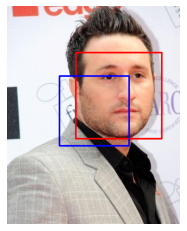

2/2 [==============================] - 0s 26ms/step
[ 13  76 239 302]


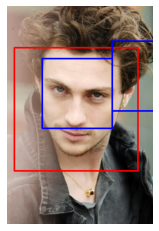

3/3 [==============================] - 0s 57ms/step
[ 92 144 281 333]


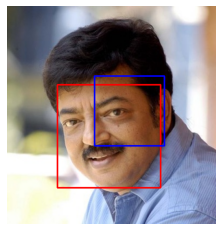

1/1 [==============================] - 0s 62ms/step
[ 44  71 135 162]


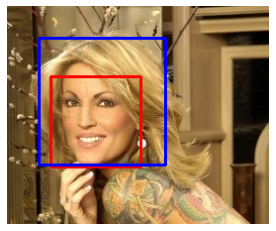

3/3 [==============================] - 0s 61ms/step
[103 149 288 334]


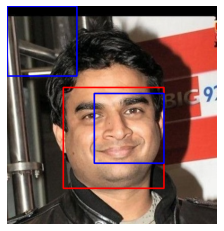

2/2 [==============================] - 0s 24ms/step
[ 67  82 207 222]


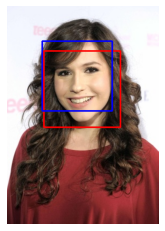

2/2 [==============================] - 0s 55ms/step
[137  38 323 224]


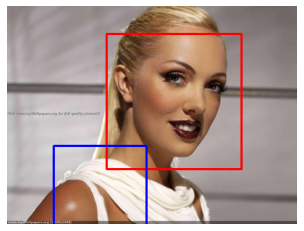

2/2 [==============================] - 0s 26ms/step
[ 43  88 215 260]


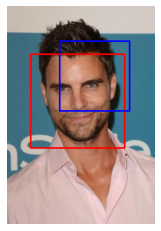

2/2 [==============================] - 0s 27ms/step
[ 62  66 221 225]


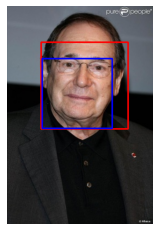

2/2 [==============================] - 0s 43ms/step
[ 42  75 268 301]


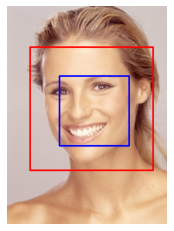

3/3 [==============================] - 0s 36ms/step
[ 46  84 241 279]


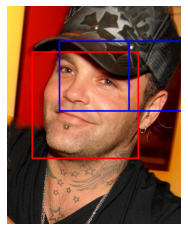

2/2 [==============================] - 0s 26ms/step
[ 53  89 254 290]


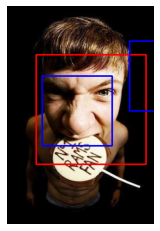

3/3 [==============================] - 0s 48ms/step
[ 99  80 239 220]


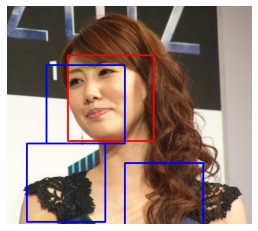

2/2 [==============================] - 0s 49ms/step
[ 63  96 236 269]


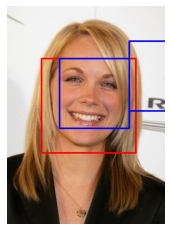

3/3 [==============================] - 0s 47ms/step
[128 108 281 261]


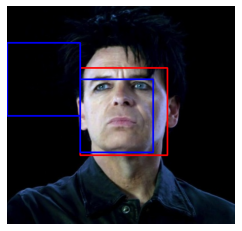

3/3 [==============================] - 0s 47ms/step
[ 53 113 272 332]


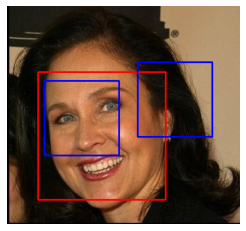

2/2 [==============================] - 0s 25ms/step
[165  36 263 134]


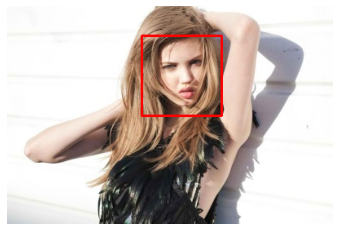

2/2 [==============================] - 0s 40ms/step
[ 32 101 234 303]


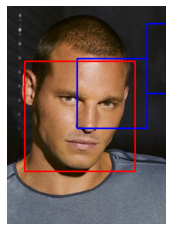

2/2 [==============================] - 0s 26ms/step
[ 55 105 226 276]


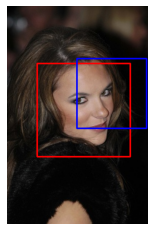

2/2 [==============================] - 0s 28ms/step
[ 61  14 186 139]


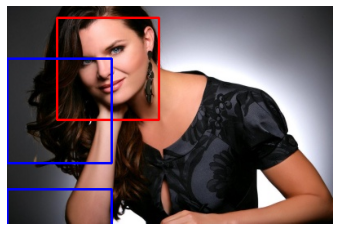

2/2 [==============================] - 0s 56ms/step
[ 60 130 254 324]


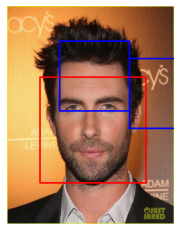

2/2 [==============================] - 0s 26ms/step
[ 33 107 192 266]


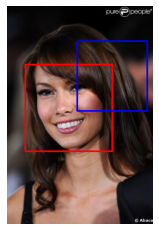

2/2 [==============================] - 0s 48ms/step
[ 81  80 234 233]


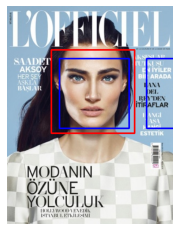

3/3 [==============================] - 0s 48ms/step
[ 95 127 273 305]


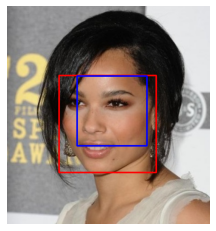

2/2 [==============================] - 0s 24ms/step
[ 63  83 198 218]


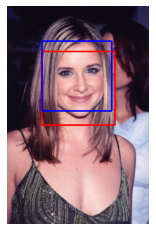

2/2 [==============================] - 0s 58ms/step
[105  32 290 217]


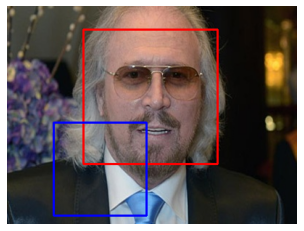

2/2 [==============================] - 0s 30ms/step
[ 53  69 250 266]


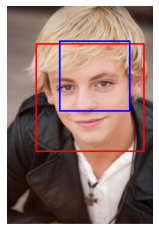

3/3 [==============================] - 0s 35ms/step
[131  56 259 184]


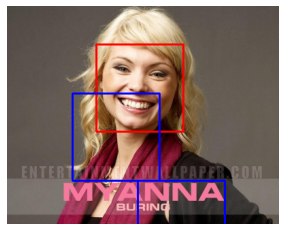

1/1 [==============================] - 0s 62ms/step
[ 77 103 185 211]


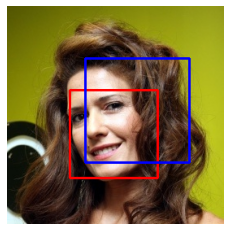

3/3 [==============================] - 0s 48ms/step
[106 101 319 314]


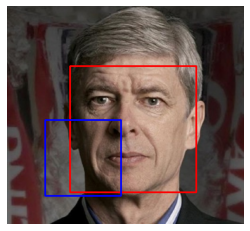

2/2 [==============================] - 0s 53ms/step
[ 45 108 236 299]


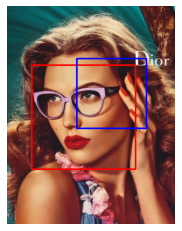

2/2 [==============================] - 0s 33ms/step
[ -3  95 265 363]


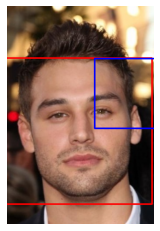

3/3 [==============================] - 0s 48ms/step
[ 77 192 175 290]


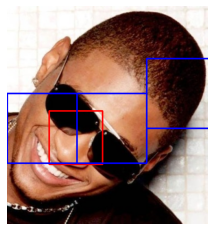

2/2 [==============================] - 0s 56ms/step
[ 79 108 242 271]


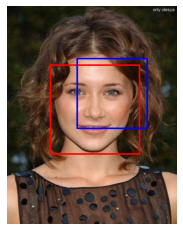

2/2 [==============================] - 0s 51ms/step
[ 97 100 248 251]


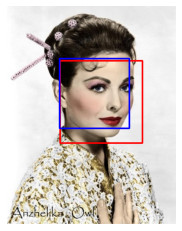

2/2 [==============================] - 0s 26ms/step
[ 38  98 207 267]


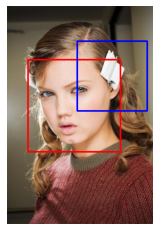

2/2 [==============================] - 0s 25ms/step
[ 12  93 169 250]


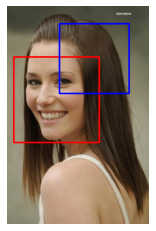

3/3 [==============================] - 0s 46ms/step
[149  54 252 157]


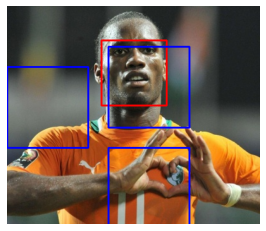

3/3 [==============================] - 0s 35ms/step
[167  27 399 259]


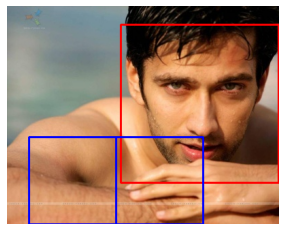

3/3 [==============================] - 0s 41ms/step
[ 77  73 286 282]


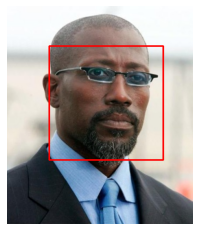

2/2 [==============================] - 0s 59ms/step
[ 74  91 254 271]


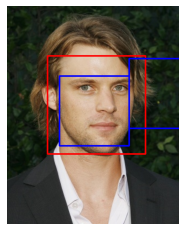

1/1 [==============================] - 0s 58ms/step
[118  77 232 191]


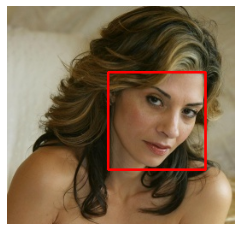

2/2 [==============================] - 0s 49ms/step
[ 98  94 280 276]


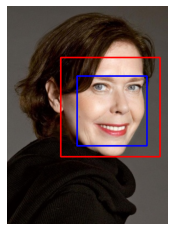

2/2 [==============================] - 0s 29ms/step
[ 69 123 186 240]


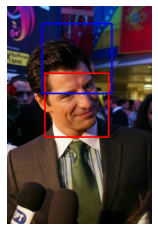

2/2 [==============================] - 0s 15ms/step
[ 71 108 249 286]


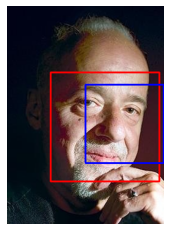

2/2 [==============================] - 0s 57ms/step
[ 79  67 258 246]


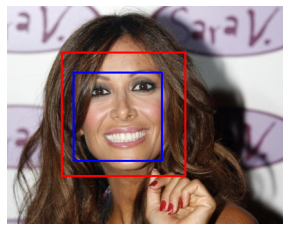

3/3 [==============================] - 0s 69ms/step
[130  71 245 186]


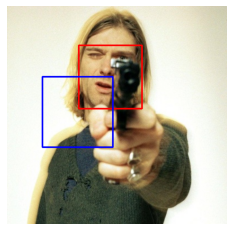

3/3 [==============================] - 0s 42ms/step
[ 51 101 197 247]


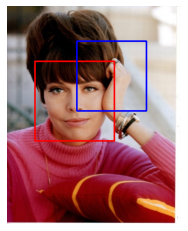

2/2 [==============================] - 0s 57ms/step
[ 85  99 237 251]


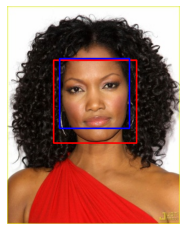

2/2 [==============================] - 0s 26ms/step
[ 18 104 214 300]


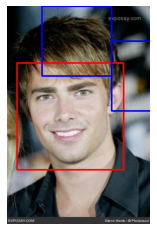

In [45]:
'''
Afinar parametros:
    threshold_p
    overlap_threshold
    non_max_threshold
'''

non_max_threshold = 0.8
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 50
stride = 32
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict(patches_feature_representation)
        face_probabilities = scores[:,0]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.1)
    else:
        selected_bbox = []
    print(gt_bbox)
    show_image_with_bbox(img, selected_bbox,gt_bbox)

## Evaluate Detector

In [19]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict(patches_feature_representation)  
    print(scores)
    ## Positive Face Probabilities
    face_probabilities = scores[:,0]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

 36%|███▌      | 63/175 [00:00<00:00, 317.40it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 329.22it/s]


34/34 [==============================] - 2s 63ms/step
[[1.1702720e-04]
 [5.8143534e-05]
 [2.8969784e-05]
 ...
 [4.3207309e-03]
 [3.9746552e-03]
 [3.2907373e-03]]
24/24 [==============================] - 2s 65ms/step
[[3.06247342e-02]
 [3.65208127e-02]
 [3.88086848e-02]
 [3.71950604e-02]
 [3.52987982e-02]
 [3.06631271e-02]
 [2.67100260e-02]
 [2.09266618e-02]
 [1.60184801e-02]
 [1.44050643e-02]
 [1.36768268e-02]
 [1.22844670e-02]
 [1.48670496e-02]
 [1.87154561e-02]
 [2.06362233e-02]
 [2.73009297e-02]
 [2.74660271e-02]
 [2.33698841e-02]
 [3.08599193e-02]
 [3.18765752e-02]
 [3.26136537e-02]
 [3.12300418e-02]
 [3.06706931e-02]
 [2.53528878e-02]
 [2.27249060e-02]
 [1.96222290e-02]
 [1.69617273e-02]
 [1.62800737e-02]
 [1.36729218e-02]
 [9.86275077e-03]
 [1.14338668e-02]
 [1.58006959e-02]
 [1.72894783e-02]
 [2.19166353e-02]
 [2.75200866e-02]
 [2.58490499e-02]
 [2.80872062e-02]
 [3.09381727e-02]
 [2.96223983e-02]
 [2.85456441e-02]
 [2.78289374e-02]
 [2.87108719e-02]
 [2.71956548e-02]
 [2.139558

In [20]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

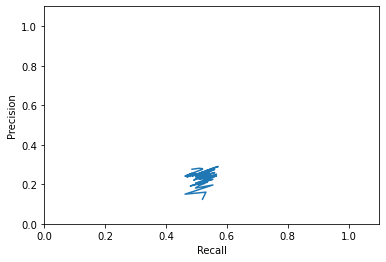

In [21]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [22]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.1416759]


### Implementacion SVM:

### Implementacion CNN: